# __CA03: Decision Tree Algorithm__
2/25/25

In [1150]:
#Import required packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.tree import plot_tree

## (1) Data Source and Contents

The dataset is obtained from the Census Bureau and represents the salaries of individuals along with seven demographic variables. The following is a description of our dataset:

- **Number of target classes:** 2 (`'>50K'` and `'<50K'`) [Labels: 1, 0]
- **Number of attributes (Columns):** 7
- **Number of instances (Rows):** 48,842 rowsurce: 

In [986]:
#Data Source: The following exact “path” is used as the data source: 
data = "git"
df = pd.read_csv(data)

In [988]:
df.head(5)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


__#Q1: Why does it make sense to discretize columns for this problem?__
This problem is trying to predict the income of individuals based on demographic variables. It makes sense to discretize the columns here as it similifies the process by converting the categorical variables into meaningful categories. It also reduces noise leading to a more interpretable model.

__#Q2: What might be the issues if we did not discretize the columns?__
In this case, as we are utilizing decsion trees for our predictions, not discretizing the columns may lead our decisions trees to not have clear split points leading to overfitting and unneccessary model complexity.The model may then be difficult to interpret and it could also be much more sensitive to noise.

## (2) Data Quality Analysis (DQA)

In [990]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [992]:
#Perform a Data Quality Analysis to find missing values, outliers, NaNs etc. 

print(df.isnull().sum())


hours_per_week_bin    0
occupation_bin        0
msr_bin               0
capital_gl_bin        0
race_sex_bin          0
education_num_bin     0
education_bin         0
workclass_bin         0
age_bin               0
flag                  0
y                     0
dtype: int64


In [994]:
#Display descriptive statistics of each column 
df.describe(include='all') 

#each column starts with a letter so we need to clean this first

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842.000000
unique,5,5,3,3,3,5,5,2,5,2,NaN
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,NaN
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239282
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426649
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [996]:
# A function that removes a leading letter followed by a period and optional whitespace (reference df in question 1).
def remove_extras(values):
    return values.str.replace(r'^[a-zA-Z]\.\s*', '', regex=True) #Here I am using regex to remove(a-z or A-Z), period, and any white spaces

#Applying the fundtion to the entire datafram using a for loop
for col in df.select_dtypes(include=['object']).columns:
    df[col] = remove_extras(df[col])

In [998]:
df.head(5)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,income,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,income,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,income,36-40 & 56-60,train,0
3,31-40,Low,High,= 0,Mid,0-8,Low,income,40-55,train,0
4,31-40,High,High,= 0,Low,13,Bachelors,income,26-30 & 71-100,train,0


In [1000]:
df.tail() #the y value is the target variable (incomes greater than $50k or less than/equal to $50k)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
48837,31-40,High,Mid,= 0,Mid,13,Bachelors,income,36-40 & 56-60,test,0
48838,31-40,Mid - Low,Low,= 0,Mid,9-12,Mid,no income,31-35 & 61-70,test,0
48839,41-50 & 61-70,High,High,= 0,High,13,Bachelors,income,36-40 & 56-60,test,0
48840,31-40,Mid - Low,Low,> 0,High,13,Bachelors,income,40-55,test,0
48841,51-60,High,High,= 0,High,13,Bachelors,income,31-35 & 61-70,test,1


In [1002]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [1004]:
df.duplicated().sum()

40012

In [1006]:
#I want to take a closer look at dupliate rows
duplicate_rows = df[df.duplicated(keep=False)]
print(duplicate_rows.head(10))

   hours_per_week_bin occupation_bin msr_bin capital_gl_bin race_sex_bin  \
0               31-40      Mid - Low     Mid            > 0         High   
1                0-30           High    High            = 0         High   
2               31-40            Low     Mid            = 0         High   
3               31-40            Low    High            = 0          Mid   
5               31-40           High    High            = 0          Mid   
6                0-30            Low     Mid            = 0          Low   
7       41-50 & 61-70           High    High            = 0         High   
8       41-50 & 61-70           High     Mid            > 0          Mid   
9               31-40           High    High            > 0         High   
11              31-40           High    High            = 0         High   

   education_num_bin education_bin workclass_bin         age_bin   flag  y  
0                 13     Bachelors        income   36-40 & 56-60  train  0  
1        

In [1008]:
df_clean = df.drop_duplicates()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8830 entries, 0 to 48840
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  8830 non-null   object
 1   occupation_bin      8830 non-null   object
 2   msr_bin             8830 non-null   object
 3   capital_gl_bin      8830 non-null   object
 4   race_sex_bin        8830 non-null   object
 5   education_num_bin   8830 non-null   object
 6   education_bin       8830 non-null   object
 7   workclass_bin       8830 non-null   object
 8   age_bin             8830 non-null   object
 9   flag                8830 non-null   object
 10  y                   8830 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 827.8+ KB


In [1010]:
cardinalities = df_clean.select_dtypes(include=['object']).nunique()
print("Cardinality for each categorical (binned) column:")
print(cardinalities)

Cardinality for each categorical (binned) column:
hours_per_week_bin    5
occupation_bin        5
msr_bin               3
capital_gl_bin        3
race_sex_bin          3
education_num_bin     5
education_bin         5
workclass_bin         2
age_bin               5
flag                  2
dtype: int64


In [1012]:
categorical_columns = df_clean.select_dtypes(include=['object']).columns #I want to take a closer look at the binned columns
for feature in categorical_columns:
    print(f"\nUnique values for {feature}:")
    print(df_clean[feature].value_counts())


Unique values for hours_per_week_bin:
hours_per_week_bin
31-40            3360
41-50 & 61-70    2035
0-30             1752
51-60            1200
71-100            483
Name: count, dtype: int64

Unique values for occupation_bin:
occupation_bin
High          2470
Mid - Low     2444
Mid - Mid     1890
Low           1190
Mid - High     836
Name: count, dtype: int64

Unique values for msr_bin:
msr_bin
High    3741
Mid     3291
Low     1798
Name: count, dtype: int64

Unique values for capital_gl_bin:
capital_gl_bin
= 0    5822
> 0    1813
< 0    1195
Name: count, dtype: int64

Unique values for race_sex_bin:
race_sex_bin
High    4640
Mid     3244
Low      946
Name: count, dtype: int64

Unique values for education_num_bin:
education_num_bin
9-12    3761
13      2108
0-8     1518
14       909
15+      534
Name: count, dtype: int64

Unique values for education_bin:
education_bin
Mid          3761
Bachelors    2108
Low          1518
Masters       909
High          534
Name: count, dtype: int64


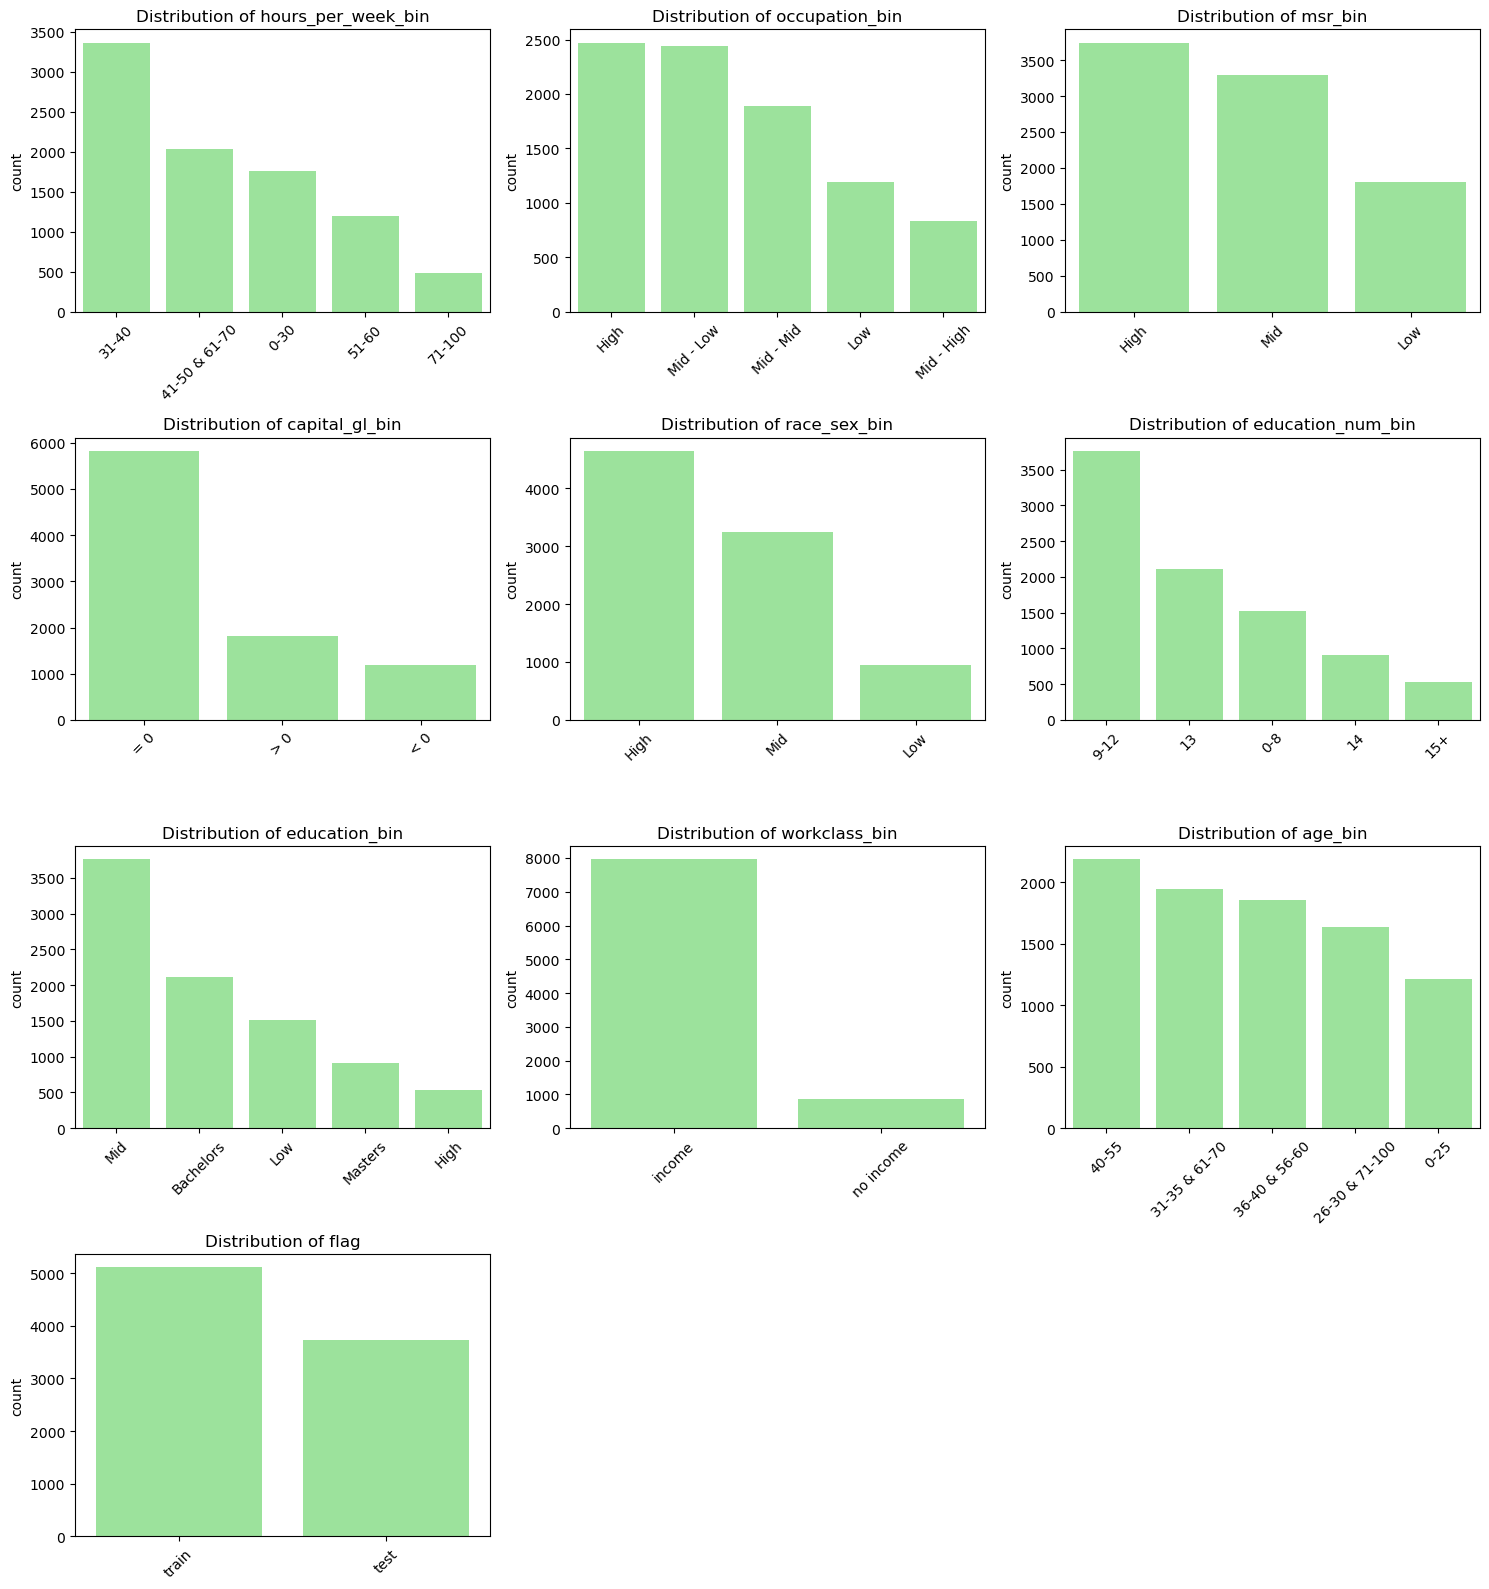

In [1014]:
#I want to visualize the discrepencies in the categorical variable bins by utilizing small multiples.
ncols = 3
nrows = (len(categorical_columns) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    ax = axes[i]
    order = df_clean[col].value_counts().index
    sns.countplot(data=df_clean, x=col, order=order, ax=ax, color="lightgreen")
    ax.set_title(f"Distribution of {col}")
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("")
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [1016]:
#I want to double check that there are no missing values
missing_rows = df_clean[df_clean.isna().any(axis=1)]
print("Rows with missing values:")
print(missing_rows.head())

Rows with missing values:
Empty DataFrame
Columns: [hours_per_week_bin, occupation_bin, msr_bin, capital_gl_bin, race_sex_bin, education_num_bin, education_bin, workclass_bin, age_bin, flag, y]
Index: []


In [1018]:
#Taking a closer look at the flag feature (testing and training data).
flag_percentages = df_clean['flag'].value_counts(normalize=True) * 100
print("Percentage distribution for testing and training data:")
print(flag_percentages)

Percentage distribution for testing and training data:
flag
train    57.825595
test     42.174405
Name: proportion, dtype: float64


In [1020]:
#Taking a closer look at the age feature.
df_clean['age_bin'] = df_clean['age_bin'].str.strip().str.replace(r'\s*&\s*', ' & ', regex=True)
print(df_clean['age_bin'].unique())

['36-40 & 56-60' '40-55' '26-30 & 71-100' '31-35 & 61-70' '0-25']


C:\Users\ashle\AppData\Local\Temp\ipykernel_10040\2432391906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['age_bin'] = df_clean['age_bin'].str.strip().str.replace(r'\s*&\s*', ' & ', regex=True)


In [1162]:
df_clean['hours_per_week_bin'].unique()

array(['31-40', '0-30', '41-50 & 61-70', '71-100', '51-60'], dtype=object)

In [1022]:
#Taking a closer look at the workclass_bin feature.
workclass_percentages = df_clean['workclass_bin'].value_counts(normalize=True) * 100
print("Percentage distribution for 'workclass_bin':")
print(workclass_percentages)

Percentage distribution for 'workclass_bin':
workclass_bin
income       90.169875
no income     9.830125
Name: proportion, dtype: float64


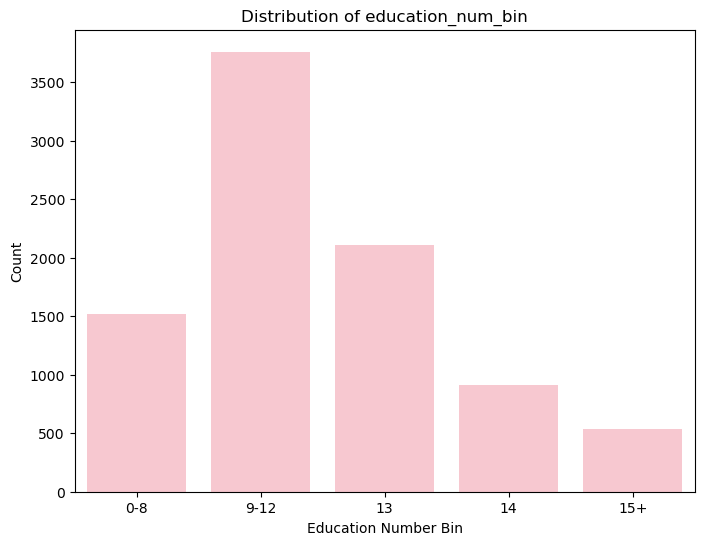

In [1024]:
#Taking a closer look at the education_num_bin feature.
order = ["0-8", "9-12", "13", "14", "15+"]
plt.figure(figsize=(8, 6))
sns.countplot(data=df_clean, x='education_num_bin', order=order, color="pink")
plt.title("Distribution of education_num_bin")
plt.xlabel("Education Number Bin")
plt.ylabel("Count")
plt.show()

### __Data Quality Report__

In [1028]:
report = """
1. Missing Values:
   - There are no missing values in the dataset.

2. General Observations:
   - Significant skewness is observed in several variables, which may indicate the presence
     of outliers that require further investigation.
    -There are quite  a bit of duplicates which I removed leaving up with just over 8000 observations.

3. Feature-Specific Observations:

   Flag:
     - Training and testing data are split about 58%/43% after duplicates are removed. We should resplit this.

   Age:
     - Age bins are mostly normally distributed.
     - However, overlapping ranges (36-40 & 56-60, 26-30 & 71-100, and 31-35 & 61-70) may 
       complicate interpretation and reduce predictive value.

   Workclass_bin:
     - Only 5.7% of entries are labeled "no income" versus 94.2% "income".
     - This imbalance suggests the "no income" category might be redundant, as it likely 
       corresponds to individuals earning <$50K.
     - Consider dropping or re-evaluating this feature.

   Education_bin:
     - The distribution is imbalanced, with the "Mid" category dominating.
     - This imbalance should be considered during encoding and model development.

   Education_num_bin:
     - A slight right skew is observed; the majority of individuals fall into the "9-12" years bin.
     - This central tendency suggests that the feature may be treated as an ordinal variable.

   Race_sex_bin:
     - Distribution is skewed toward the "High" category, followed by "Mid" and "Low".
     - This may reflect underlying socio-demographic differences and should be examined for potential bias.

   Capital_gl_bin:
     - The majority of inputs fall into the "= 0" category (no capital gain or loss).
     - Few entries show "> 0" or "< 0", suggesting limited predictive power unless further transformed.

   Msr_bin:
     - An ordered trend is observed with "High" being most frequent, followed by "Mid" and "Low".
     - This indicates an ordinal relationship that could be preserved with appropriate encoding.

   Occupation_bin:
     - The distribution is relatively balanced.
     - "Mid - Mid" and "Mid - Low" are the most common categories, while "Mid - High" is less frequent.

   Hours_per_week_bin:
     - "31-40" hours is the most common category, reflecting typical full-time work.
     - Other ranges (e.g., "41-50 & 61-70", "0-30", "51-60", "71-100") have fewer observations,
       indicating variations such as part-time or overtime work.

---------------------------------------------------------
Recommendations:
   - Investigate potential outliers in features with extreme or skewed distributions.
   - Consider rebalancing or transforming highly imbalanced features (e.g., Workclass_bin).
   - Use appropriate encoding: ordinal encoding for ordered features and one-hot encoding for nominal features.
---------------------------------------------------------
"""
print(report)



1. Missing Values:
   - There are no missing values in the dataset.

2. General Observations:
   - Significant skewness is observed in several variables, which may indicate the presence
     of outliers that require further investigation.
    -There are quite  a bit of duplicates which I removed leaving up with just over 8000 observations.

3. Feature-Specific Observations:

   Flag:
     - Training and testing data are split about 58%/43% after duplicates are removed. We should resplit this.

   Age:
     - Age bins are mostly normally distributed.
     - However, overlapping ranges (36-40 & 56-60, 26-30 & 71-100, and 31-35 & 61-70) may 
       complicate interpretation and reduce predictive value.

   Workclass_bin:
     - Only 5.7% of entries are labeled "no income" versus 94.2% "income".
     - This imbalance suggests the "no income" category might be redundant, as it likely 
       corresponds to individuals earning <$50K.
     - Consider dropping or re-evaluating this feature.



__Perform necessary data cleansing and transformation based on your observations from the data quality analysis__ 

In [1030]:
#Dropping rows where 'workclass_bin' = 'no income'
df_clean = df_clean[df_clean['workclass_bin'] != 'no income']

In [1032]:
df_clean['workclass_bin'].unique()

array(['income'], dtype=object)

In [1034]:
#Dropping the workclass bin because "no income" will not help us
df_clean = df_clean.drop(columns=['workclass_bin'])

In [1036]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7962 entries, 0 to 48840
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  7962 non-null   object
 1   occupation_bin      7962 non-null   object
 2   msr_bin             7962 non-null   object
 3   capital_gl_bin      7962 non-null   object
 4   race_sex_bin        7962 non-null   object
 5   education_num_bin   7962 non-null   object
 6   education_bin       7962 non-null   object
 7   age_bin             7962 non-null   object
 8   flag                7962 non-null   object
 9   y                   7962 non-null   int64 
dtypes: int64(1), object(9)
memory usage: 684.2+ KB


In [1038]:
df_clean['flag'].value_counts()

flag
train    4585
test     3377
Name: count, dtype: int64

In [1040]:
# Re-split the indices of df_clean with stratification by the target variable 'y'
train_new, test_new = train_test_split(df_clean.index, test_size=0.30, stratify=df_clean['y'], random_state=42)

# Assign new flags based on the split
df_clean.loc[train_new, 'flag'] = 'train'
df_clean.loc[test_new, 'flag'] = 'test'

# Verify new distribution
print(df_clean['flag'].value_counts(normalize=True) * 100)


flag
train    69.994976
test     30.005024
Name: proportion, dtype: float64


In [1042]:
df_clean.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,36-40 & 56-60,test,0
3,31-40,Low,High,= 0,Mid,0-8,Low,40-55,test,0
4,31-40,High,High,= 0,Low,13,Bachelors,26-30 & 71-100,test,0


In [1044]:
#Encoding 
category_col =['hours_per_week_bin','occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 
               'education_bin', 'age_bin','flag']

encoded_data = df_clean.copy() 
df_input = df_clean[category_col].copy()
enc = preprocessing.LabelEncoder()
encoder_dict = dict()
for cat in category_col:
    df_input[cat] = df_input[cat].str.lstrip()
    enc = enc.fit(list(df_input[cat]) + ['Unknown'])
    encoder_dict[cat] = [cat for cat in enc.classes_]
    encoded_data[cat] = enc.transform(df_input[cat])

In [1046]:
df_clean.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,36-40 & 56-60,test,0
3,31-40,Low,High,= 0,Mid,0-8,Low,40-55,test,0
4,31-40,High,High,= 0,Low,13,Bachelors,26-30 & 71-100,test,0


In [1048]:
encoded_data.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,age_bin,flag,y
0,1,3,2,2,0,1,0,3,2,0
1,0,0,0,1,0,1,0,4,2,0
2,1,1,2,1,0,4,4,3,1,0
3,1,1,0,1,2,0,2,4,1,0
4,1,0,0,1,1,1,0,1,1,0


In [1050]:
encoded_data.shape

(7962, 10)

In [1052]:
print(encoder_dict)

{'hours_per_week_bin': ['0-30', '31-40', '41-50 & 61-70', '51-60', '71-100', 'Unknown'], 'occupation_bin': ['High', 'Low', 'Mid - High', 'Mid - Low', 'Mid - Mid', 'Unknown'], 'msr_bin': ['High', 'Low', 'Mid', 'Unknown'], 'capital_gl_bin': ['< 0', '= 0', '> 0', 'Unknown'], 'race_sex_bin': ['High', 'Low', 'Mid', 'Unknown'], 'education_num_bin': ['0-8', '13', '14', '15+', '9-12', 'Unknown'], 'education_bin': ['Bachelors', 'High', 'Low', 'Masters', 'Mid', 'Unknown'], 'age_bin': ['0-25', '26-30 & 71-100', '31-35 & 61-70', '36-40 & 56-60', '40-55', 'Unknown'], 'flag': ['Unknown', 'test', 'train']}


In [1054]:
print("Unique flag values:", encoded_data['flag'].unique())


Unique flag values: [2 1]


In [1056]:
encoded_data.flag.unique()

array([2, 1])

In [1058]:
encoded_data[encoded_data['flag'] == 'Unknown'] #strange but no entries

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,age_bin,flag,y


In [1060]:
#Prior to building my decison tree classifier models, I need to create separate dataframes for training and testing data:

train_df = encoded_data[encoded_data['flag'] == 2].copy()
test_df  = encoded_data[encoded_data['flag'] == 1].copy()

# Drop flag column since no longer needed for modeling
train_df.drop(columns=['flag'], inplace=True)
test_df.drop(columns=['flag'], inplace=True)

# Check the shapes
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

Training Data Shape: (5573, 9)
Testing Data Shape: (2389, 9)


## (3) Build Decision Tree Classifier Models 

In [1062]:
#Use “DecisionTreeClassifier” algorithm from scikit learn
x_train = train_df.drop(columns=['y'])
y_train = train_df['y']

x_test = test_df.drop(columns=['y'])
y_test = test_df['y']

dtree = DecisionTreeClassifier(max_depth=10, random_state=101, 
                               max_features=None, min_samples_leaf=15)
dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)


## (4) Evaluate Decision Tree Performance

In [1066]:
#Calculate and display the following. Do all of these inside your Notebook. (Confusion Matrix (TP, TN, FP, FN … etc.)
#Accuracy, Precision, Recall, F1 Score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))
DTC_fp, DTC_tp, DTC_threshold = roc_curve(y_test, y_pred)
print("Threshold:", DTC_threshold)


[[1371  222]
 [ 470  326]]
              precision    recall  f1-score   support

           0       0.74      0.86      0.80      1593
           1       0.59      0.41      0.49       796

    accuracy                           0.71      2389
   macro avg       0.67      0.64      0.64      2389
weighted avg       0.69      0.71      0.69      2389

Accuracy Score: 0.7103390539974885
Recall Score: 0.40954773869346733
Precision Score: 0.5948905109489051
ROC AUC Score:  0.6350940200058673
Threshold: [inf  1.  0.]


## (5) Tune Decision Tree Performance 

Vary four hyperparameters manually and train/score the model for each set of these parameters:

- **Split Criteria**: `Entropy` or `Gini Impurity`
- **Maximum Features**: The number of features to consider when looking for the best split. If a float is provided, then `max_features` is interpreted as a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.
- **Minimum Sample Leaf**: Minimum number of samples in a leaf node to stop further splitting (becomes a leaf node).
- **Maximum Depth**: Maximum depth of the tree allowed.
llowed

In [1068]:
#-----RUN 1------
#Hyperparameter 1: Split criterion

criteria = ['gini', 'entropy']
results_run1= []

for crit in criteria:
    dtree = DecisionTreeClassifier(criterion=crit, random_state=101)
    dtree.fit(x_train, y_train)
    y_pred = dtree.predict(x_test)
    
    a_run1 = accuracy_score(y_test, y_pred)
    prec_run1 = precision_score(y_test, y_pred)
    rec_run1 = recall_score(y_test, y_pred)
    f1_run1 = f1_score(y_test, y_pred)
    
    results_run1.append({
        'criterion': crit, 
        'accuracy': a_run1,
        'precision': prec_run1,
        'recall': rec_run1,
        'f1': f1_run1
    })
    
results_run1 = pd.DataFrame(results_run1)
print("RUN 1: Hyperparameter 1 -- Varying Split Criterion\n")
print(results_run1)


RUN 1: Hyperparameter 1 -- Varying Split Criterion

  criterion  accuracy  precision    recall        f1
0      gini  0.590624   0.358696  0.290201  0.320833
1   entropy  0.588949   0.356923  0.291457  0.320885


In [1070]:
#----RUN 2-----
#Hyperparameter 2: Minimum Sample Leafs

min_samples_leaf_options = [5, 10, 15, 20, 25, 30, 35, 40]
results_run2 = []
best_criterion = 'gini'  # In Run 1 we found that 'gini' had better accuracy

for min_leaf in min_samples_leaf_options:
    dtree = DecisionTreeClassifier(criterion=best_criterion, random_state=101, min_samples_leaf=min_leaf)
    dtree.fit(x_train, y_train)
    y_pred = dtree.predict(x_test)
    
    #Performance metrics
    a_run2 = accuracy_score(y_test, y_pred)
    prec_run2 = precision_score(y_test, y_pred)
    rec_run2 = recall_score(y_test, y_pred)
    f1_run2 = f1_score(y_test, y_pred)
    
    # Append the results for this min_samples_leaf value
    results_run2.append({
        'min_samples_leaf': min_leaf,
        'accuracy': a_run2,
        'precision': prec_run2,
        'recall': rec_run2,
        'f1': f1_run2
    })

# Convert the results to a DataFrame for display
results_run2_df = pd.DataFrame(results_run2)
print("\nRUN 2: Hyperparameter 2--Minimum Samples per Leaf")
print(results_run2_df)



RUN 2: Hyperparameter 2--Minimum Samples per Leaf
   min_samples_leaf  accuracy  precision    recall        f1
0                 5  0.647133   0.462875  0.368090  0.410077
1                10  0.687735   0.541118  0.413317  0.468661
2                15  0.699037   0.569620  0.395729  0.467013
3                20  0.705316   0.582143  0.409548  0.480826
4                25  0.706990   0.588235  0.402010  0.477612
5                30  0.712013   0.591837  0.437186  0.502890
6                35  0.714943   0.607477  0.408291  0.488355
7                40  0.717874   0.609712  0.425879  0.501479


In [1072]:
#-----RUN 3-----
#Hyperparameter 3: Maximum Features

max_features_options = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results_run3 = []
best_min_samples_leaf = 40  

for max_feat in max_features_options:
    dtree = DecisionTreeClassifier(criterion=best_criterion,random_state=101,min_samples_leaf=best_min_samples_leaf, max_features=max_feat)
    dtree.fit(x_train, y_train)
    y_pred = dtree.predict(x_test)
    
    #evaluation metrics
    a_run3 = accuracy_score(y_test, y_pred)
    prec_run3 = precision_score(y_test, y_pred)
    rec_run3 = recall_score(y_test, y_pred)
    f1_run3 = f1_score(y_test, y_pred)
    
    # Append results
    results_run3.append({
        'max_features': max_feat,
        'accuracy': a_run3,
        'precision': prec_run3,
        'recall': rec_run3,
        'f1': f1_run3
    })

# Convert to DataFrame
results_run3_df = pd.DataFrame(results_run3)
print("\nRUN 3: Hyperparameter 3--Maximum Features")
print(results_run3_df)


RUN 3: Hyperparameter 3--Maximum Features
   max_features  accuracy  precision    recall        f1
0           0.3  0.714943   0.585949  0.492462  0.535154
1           0.4  0.712851   0.605769  0.395729  0.478723
2           0.5  0.718711   0.609541  0.433417  0.506608
3           0.6  0.718711   0.609541  0.433417  0.506608
4           0.7  0.724571   0.629699  0.420854  0.504518
5           0.8  0.712851   0.608268  0.388191  0.473926


In [1074]:
#----RUN 4------
#Hyperparameter 4: Maximum Depth

max_depth_options = [2, 4, 6, 8, 10, 12, 14, 16]
results_run4 = []

for depth in max_depth_options:
    dtree = DecisionTreeClassifier(
        criterion=best_criterion,
        random_state=101,
        min_samples_leaf=best_min_samples_leaf,
        max_features=results_run3_df.loc[results_run3_df['accuracy'].idxmax(), 'max_features'],
        max_depth=depth
    )
    dtree.fit(x_train, y_train)
    y_pred = dtree.predict(x_test)
    
    a_run4 = accuracy_score(y_test, y_pred)
    prec_run4 = precision_score(y_test, y_pred)
    rec_run4 = recall_score(y_test, y_pred)
    f1_run4 = f1_score(y_test, y_pred)
    
    results_run4.append({
        'max_depth': depth,
        'accuracy': a_run4,
        'precision': prec_run4,
        'recall': rec_run4,
        'f1': f1_run4
    })
    
results_run4_df = pd.DataFrame(results_run4)
print("\nRUN 4: Hyperparameter 4 -- Varying Maximum Depth")
print(results_run4_df)



RUN 4: Hyperparameter 4 -- Varying Maximum Depth
   max_depth  accuracy  precision    recall        f1
0          2  0.701549   0.548996  0.584171  0.566038
1          4  0.707828   0.610860  0.339196  0.436187
2          6  0.722897   0.623162  0.425879  0.505970
3          8  0.724990   0.630885  0.420854  0.504898
4         10  0.719967   0.628283  0.390704  0.481797
5         12  0.724571   0.629699  0.420854  0.504518
6         14  0.724571   0.629699  0.420854  0.504518
7         16  0.724571   0.629699  0.420854  0.504518


__Q.3:  Decision Tree Hyper-parameter variation vs. performance__ 

Here your goal is to determine the hyper-parameter values for the “best-performing” tree with respect to “accuracy”

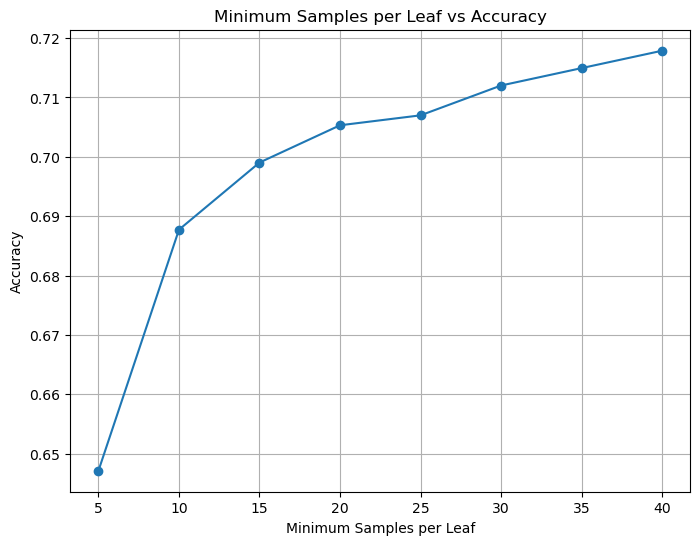

In [1076]:
# Graph 1: Minimum Samples per Leaf vs. Accuracy (from Run 2)
plt.figure(figsize=(8, 6))
plt.plot(results_run2_df['min_samples_leaf'], results_run2_df['accuracy'], marker='o', linestyle='-')
plt.xlabel('Minimum Samples per Leaf')
plt.ylabel('Accuracy')
plt.title('Minimum Samples per Leaf vs Accuracy')
plt.grid(True)
plt.show()

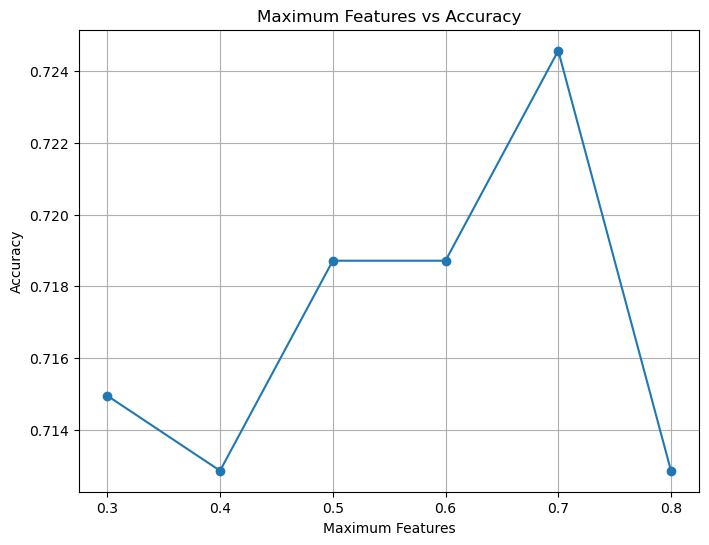

In [1078]:
# Graph 2: Maximum Features vs. Accuracy (from Run 3)
plt.figure(figsize=(8, 6))
plt.plot(results_run3_df['max_features'], results_run3_df['accuracy'], marker='o', linestyle='-')
plt.xlabel('Maximum Features')
plt.ylabel('Accuracy')
plt.title('Maximum Features vs Accuracy')
plt.grid(True)
plt.show()

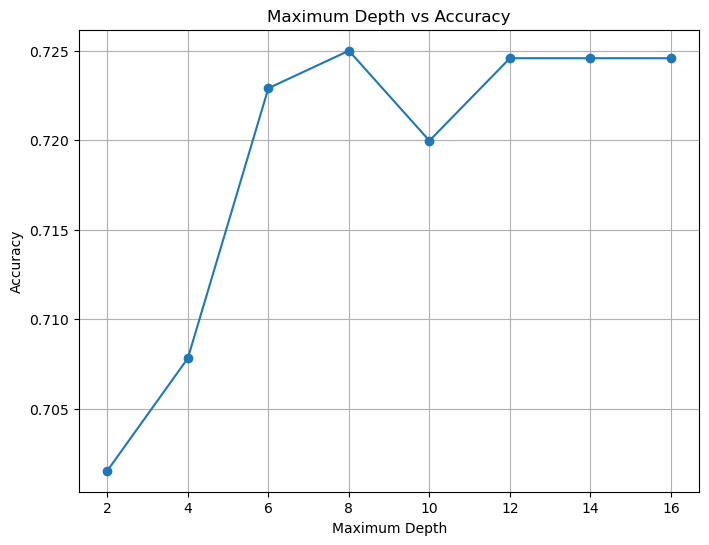

In [1080]:
# Graph 3: Maximum Depth vs. Accuracy (from Run 4)
plt.figure(figsize=(8, 6))
plt.plot(results_run4_df['max_depth'], results_run4_df['accuracy'], marker='o', linestyle='-')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Maximum Depth vs Accuracy')
plt.grid(True)
plt.show()

## (6)  Visualize Your Best Decision Tree using GraphViz 

In [1095]:
#Once you have the best hyper-parameters from 4 runs, you will know the hyper-parameter 
#combination of your BEST-performing Tree with respect to “accuracy”. Use these set of 
#hyper-parameters to build the BEST Tree, record it’s performance parameter (all of them) 
#and then “visualize” this best tree.

best_tree = DecisionTreeClassifier(
    criterion='gini',
    random_state=101,
    min_samples_leaf=40,
    max_features=0.7,
    max_depth=8
)

# Train/predict the final model
best_tree.fit(x_train, y_train)
y_pred_best = best_tree.predict(x_test)

# Record performance metrics
a_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best)
rec_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print("Final Model Performance:")
print("Accuracy:  ", a_best)
print("Precision: ", prec_best)
print("Recall:    ", rec_best)
print("F1 Score:  ", f1_best)


Final Model Performance:
Accuracy:   0.7249895353704479
Precision:  0.6308851224105462
Recall:     0.42085427135678394
F1 Score:   0.5048982667671439


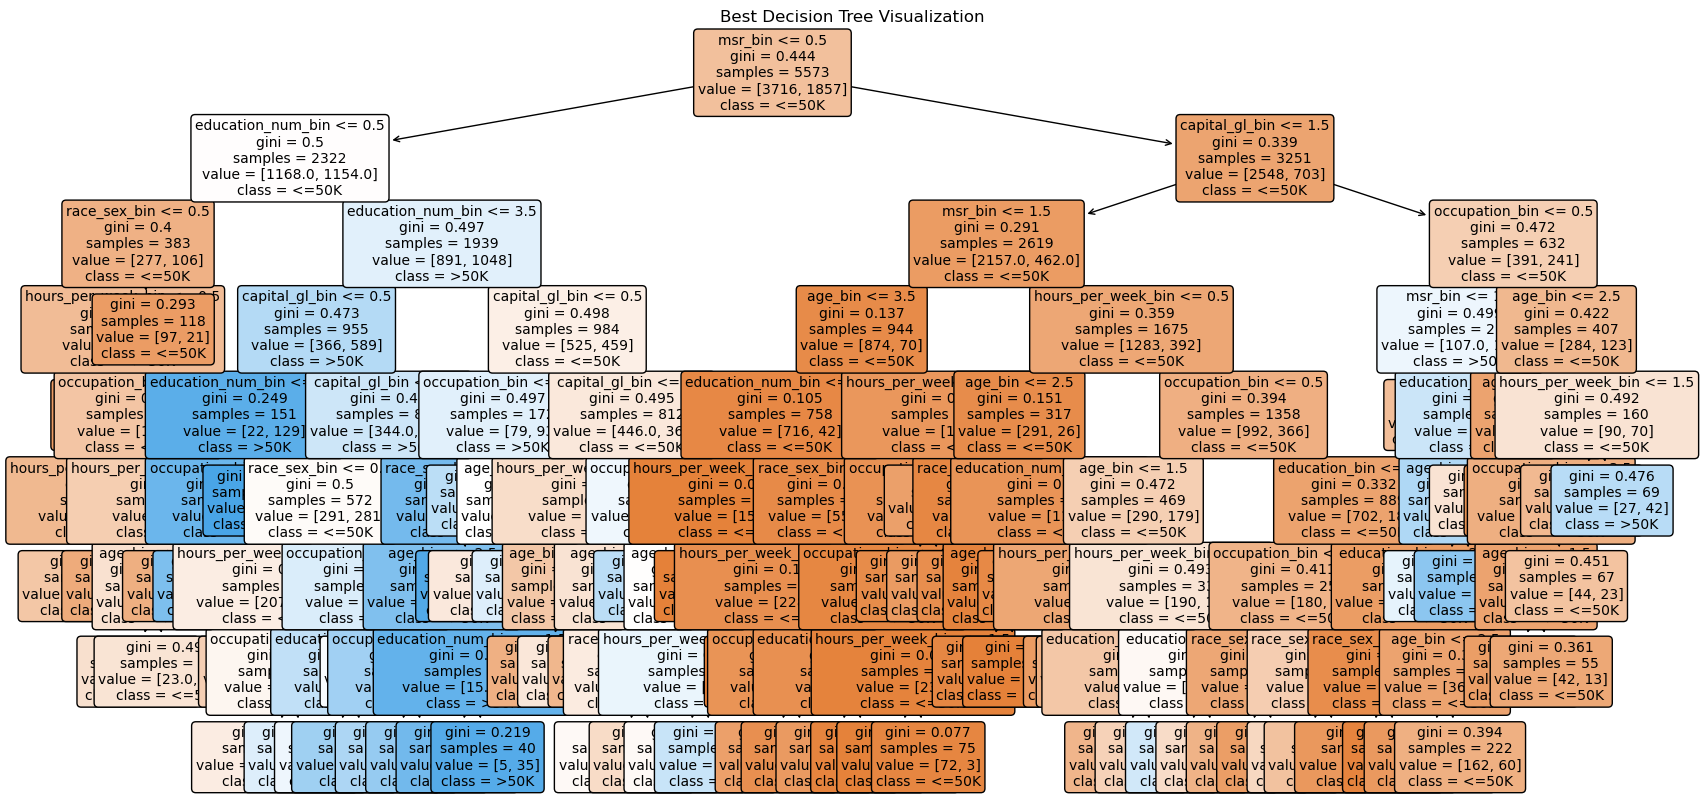

In [1099]:
#Visualizing the best tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree,
          feature_names=x_train.columns,
          class_names=["<=50K", ">50K"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Best Decision Tree Visualization")
plt.show()

## (7) Conclusion

In [1115]:
#Explain your observations from the above performance tuning effort.  

In [1123]:
import time
start = time.time()
best_tree.fit(x_train, y_train)
end = time.time()
total_run_time = end - start
print("Total training time for the best tree: {:.4f} seconds".format(total_run_time))

Total training time for the best tree: 0.0096 seconds


__Q.4 How long was your total run time to train the best model?__  

The total run time was about 0.0096 seconds

__Q.5 Did you find the BEST TREE?__ 

Yes, after tuning the hyperparameters across 4 runs, I was able to find the tree with the highest accuracy across the test set. The best tree was found to be split on the gini criterion, 40 minimum samples per leaf, 0.7 maximum features, and 8 as the max depth. The accuracy of this was about 72.5% which is higher than the initial accuracy.

__Q.6 Write your observations from the visualization of the best tree__ 

The visualization of the best tree as seen above indicates that there is a modereate depth of about 9 levels showing that the hyperparameters did a pretty good job of 'pruning' the tree. This also shows that overfitting is avoided.

We also see that there were meaningful feature splits like the root node splitting on education_num_bin.

The actual visualization of the tree is also interpretable with different colors. Overall the visualization shows that this is a good option for model deployment. 

__Q.7 Will this Tree “overfit”? (Hint: Is this tree “fully grown”)__ 

The tree e visualization a e hyperparamets seem to show the tree isn't fully grownon or overfitThere was a constraint on the max depth ) and a m #er of samples per leaf, which helped prunbranches that were likely e unnecessa. Along with this, , the test seamd training set t performancare s comparable to the training set performancesuggesting overfitting isn't occurring. .



## (8) Prediction using your “trained” Decision Tree Model 

#Based on the Performance Tuning effort in the previous section, pick your BEST 
#PERFORMING TREE. Now make prediction of a “new” individual’s Income Category ( <=50K, 
#or >50K ) with the following information. Do this in your Notebook. 
- Occupation Category = Mid - Low
- Marriage Status & Relationships = High
- Capital Gain = Yes
- Race-Sex Group = Mid
- Number of Years of Education = 12
- Education Category = High
- Work Class = Income
- Age = 58 

Hint: You have to create a single record dataframe with the above values with the 
EXACT same dataframe structure you have used for “training”. Then use the 
“model.predict()” object using this single-record dataframe. Also, note that you need to 
do exact same “binning” and “encoding” of the values above as per the original data file 
before you can use your dataframe for prediction. 

In [1164]:
#I have to create the single record in the same way
new_record = {
    'hours_per_week_bin': '41-50 & 61-70',
    'occupation_bin': 'Mid - Low',
    'msr_bin': 'High', 
    'capital_gl_bin': '> 0',
    'race_sex_bin': 'Mid',
    'education_num_bin': '9-12',
    'education_bin': 'High',
    #'workclass_bin': 'income',   ##commented out because I removed this feature
    'age_bin': '36-40 & 56-60'
}

#DataFrame
new_df = pd.DataFrame([new_record])
print("New record before encoding:")
print(new_df)

New record before encoding:
  hours_per_week_bin occupation_bin msr_bin capital_gl_bin race_sex_bin  \
0      41-50 & 61-70      Mid - Low    High            > 0          Mid   

  education_num_bin education_bin        age_bin  
0              9-12          High  36-40 & 56-60  


In [1166]:
# Apply the remove_extras function to all object-type columns in the new record
for col in new_df.select_dtypes(include=['object']).columns:
    new_df[col] = remove_extras(new_df[col])

print("\nNew record AFTER preprocessing:")
print(new_df)

for col in new_df.columns:
    # Create a new LabelEncoder instance
    le = preprocessing.LabelEncoder()
    le.classes_ = np.array(encoder_dict[col])
    new_df[col] = le.transform(new_df[col])

print("\nNew record AFTER encoding:")
print(new_df)



New record AFTER preprocessing:
  hours_per_week_bin occupation_bin msr_bin capital_gl_bin race_sex_bin  \
0      41-50 & 61-70      Mid - Low    High            > 0          Mid   

  education_num_bin education_bin        age_bin  
0              9-12          High  36-40 & 56-60  

New record AFTER encoding:
   hours_per_week_bin  occupation_bin  msr_bin  capital_gl_bin  race_sex_bin  \
0                   2               3        0               2             2   

   education_num_bin  education_bin  age_bin  
0                  4              1        3  


In [1174]:
# Predict the class for the new record using the best decision tree model
predicted_class = best_tree.predict(new_df)
predicted_proba = best_tree.predict_proba(new_df)

# Interpret the predicted class
if predicted_class[0] == 1:
    prediction_text = 'Income > $50K'
else:
    prediction_text = 'Income <= $50K'

print("Predicted Income Category:", prediction_text)
print("Prediction Probabilities:", predicted_proba)


Predicted Income Category: Income > $50K
Prediction Probabilities: [[0.41935484 0.58064516]]


**Q.8 What is the probability that your prediction for this person is correct?**

The model predicts that the new individual has an income greater than \$50,000. The prediction probabilities are as follows:
- **41.94%** chance that the individual's income is \$50,000 or less (class 0)
- **58.06%** chance that the individual's income is greater than \$50,000 (class 1)

Since the probability for class 1 is higher, the model is about **58.06%** confident in its prediction of "Income > \$50K."


## (9) Deliverables

My assignment includes a fFully functional Notebook, Data, Readme file in a single folder at GitHu. And all All questishould bed be answered with the corresponding Question Numbersin 
Marked-down Cells isn the Notebook. 